In [1]:
import sys

import astropy.units as u
import gammapy
import matplotlib.pylab as plt
import numpy as np
import pyximport
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import FoVBackgroundModel, Models
from matplotlib import rc

# import random
sys.path.append("/home/katrin/Documents/nuisance_summary/")
sys.path.append("../../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

print(f"loaded gammapy version: {gammapy.__version__} ")
print("Supposed to be 1.0 (21-12-2022)")
rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


(None, <pyximport.pyximport.PyxImporter at 0x7fd3680a3970>)

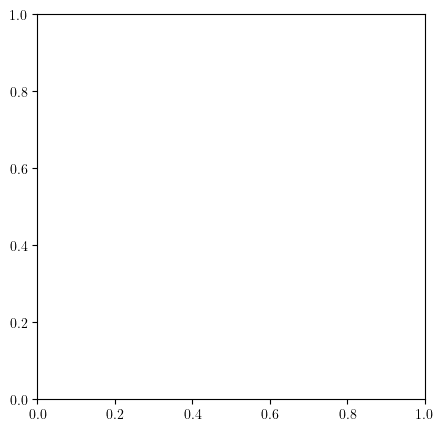

In [2]:
savefig = 1
picformat = "png"
fig, a_fake = plt.subplots(1, 1, figsize=(5.0, 5.0))

config = Dataset_load.load_config()
colors = config["colors"]["one"]

## Methods

In [3]:
def plot_asimov_spectrum(fig, ax):
    model = dataset_asimov_N.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[1],
        label="Asimov Fit with nui.",
        linestyle="solid",
    )

    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[3],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0].spectral_model
    model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color=colors[0],
        linestyle="dashed",
        label="Asimov Fit w/0 nui.",
    )
    model.plot_error(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        facecolor=colors[2],
        label="",
        alpha=1,
    )

    model = dataset_asimov.models[0]
    dataset_asimov.models[0].spectral_model.plot(
        energy_bounds=[0.3, 100] * u.TeV,
        energy_power=2,
        ax=ax,
        color="black",
        label="Input",
        linestyle="dotted",
    )

    ax.legend(loc="lower left")
    ax.set_xlim(0.3, 100)
    ax.set_ylim(1e-13, 2e-12)

## Import

### Datasets

In [4]:
scaled_amplitude = Parameter("amplitude", value=1e-12)
lambda_ = Parameter("lambda_", value=1 / 60)

dataset_asimov = Dataset_load.create_asimov(
    model="ecpl", source="PKSflare", parameters=Parameters([scaled_amplitude, lambda_])
)

shift = 0.0
tilt = 0.0
bias = 0.1
resolution = 0.1

sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / bias**2, 1 / resolution**2, 1 / zero**2, 1 / zero**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix
dataset_asimov_N.irf_model.eff_area_model.parameters.freeze_all()
dataset_asimov_N.irf_model.parameters["resolution"].frozen = False
dataset_asimov_N.irf_model.parameters["bias"].frozen = False


a_unit = dataset_asimov_N.models.parameters["amplitude"].unit

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


In [5]:
%%time
fitting = 0
if fitting:
    fit = Fit(store_trace=False)
    minuit_opts = {"tol": 0.001, "strategy": 2}
    fit.backend = "minuit"
    fit.optimize_opts = minuit_opts
    result = fit.run([dataset_asimov])
    result_N = fit.run([dataset_asimov_N])

    dataset_asimov.models.write("data/1_model.yml", overwrite=1)
    dataset_asimov_N.models.write("data/1_model_N.yml", overwrite=1)


else:
    m = Models.read("data/1_model.yml")
    dataset_asimov.models = Models(
        [
            m[0],
            FoVBackgroundModel(
                dataset_name=dataset_asimov.name,
                spectral_model=m[1].spectral_model.copy(),
            ),
        ]
    )
    path = "data/1_model_N.yml"
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)
    dataset_asimov_N.models.parameters["norm_nuisance"].frozen = True

CPU times: user 177 ms, sys: 47.2 ms, total: 224 ms
Wall time: 224 ms


In [17]:
print("lambda:")
print(1 / 60)
print(
    dataset_asimov.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov.models.parameters["lambda_"].error,
)
print(
    dataset_asimov_N.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov_N.models.parameters["lambda_"].error,
)

print(
    1 / dataset_asimov.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov.models.parameters["lambda_"].error
    / dataset_asimov.models.parameters["lambda_"].value ** 2,
)
print(
    1 / dataset_asimov_N.models.parameters["lambda_"].value,
    "pm",
    dataset_asimov_N.models.parameters["lambda_"].error
    / dataset_asimov_N.models.parameters["lambda_"].value ** 2,
)

lambda:
0.016666666666666666
0.01616887766540698 pm 0.013821913025054455
0.01605690252107785 pm 0.014110129946867675
61.847211704711064 pm 52.86988984112208
62.278512227828685 pm 54.72773464737096


In [9]:
print(dataset_asimov.models)
print(dataset_asimov_N.models)

DatasetModels

Component 0: SkyModel

  Name                      : TQLL36So
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.301   +/-    0.07             
    amplitude                     :   1.00e-12   +/- 5.5e-14 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      0.016   +/-    0.01 1 / TeV     
    alpha                 (frozen):      1.000                   
    lon_0                         :    329.680   +/-    0.00 deg         
    lat_0                         :    -30.222   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : VHYWgigq-bkg
  Datasets names            : ['VHYWgigq']
  Spectral model type       : PowerLawNormSpectralModel
  Spatial  model type       : 
  Parameters:
    norm

(0.3, 100)

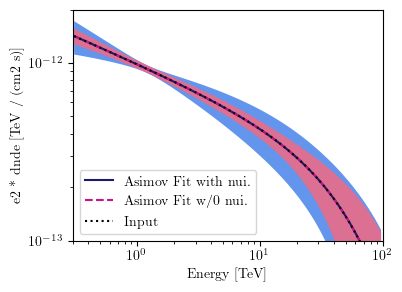

In [6]:

energy_power = 2
fig, axs = plt.subplots(1, 1, figsize=(4, 3))
plot_asimov_spectrum(fig, axs)

axs.set_xlim(0.3, 100)